# Augraphy를 사용한 이미지 증강

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2
import os
import gc
import random

from augraphy import *

import concurrent.futures

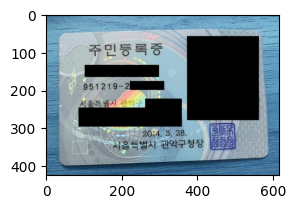

In [19]:
image = Image.open('/data/ephemeral/home/data/train/0a1b8d3c52d64052.jpg')

plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.show()

# train 이미지

In [20]:
train_df = pd.read_csv('/data/ephemeral/home/data/train.csv')
train_df

,ID,target
0,002f99746285dfdd.jpg,16
1,008ccd231e1fea5d.jpg,10
2,008f5911bfda7695.jpg,10
3,009235e4c9c07af5.jpg,4
4,00b2f44967580c74.jpg,16
...,...,...
1565,fed9e9ec4a77bc06.jpg,4
1566,feeade617aa68c45.jpg,7
1567,ff51dd281a8423f1.jpg,11
1568,ff8a6a251ce51c95.jpg,5


In [21]:
train_df = train_df[(train_df['target']==3) | (train_df['target']==4) | (train_df['target']==7) | (train_df['target']==14)]

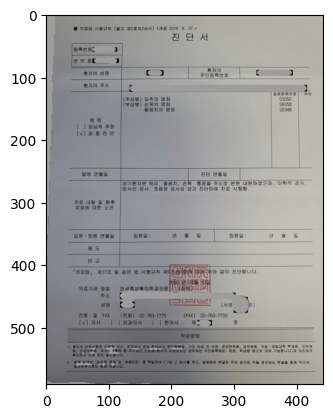

In [22]:
root_path = '/data/ephemeral/home/data/mask_deleted'

img = cv2.imread(os.path.join(root_path, train_df.iloc[0,0]))
plt.imshow(img)

# Augraphy

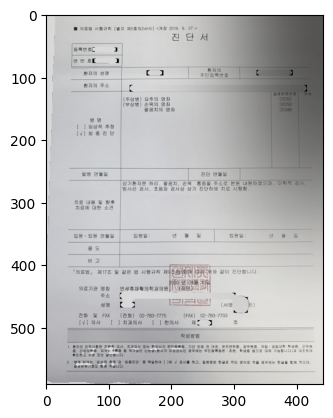

In [23]:
# augrapht 간단한 예제

pipeline = default_augraphy_pipeline()
img = cv2.imread(os.path.join(root_path, train_df.iloc[0, 0]))
#img = Image.open(os.path.join(root_path, train_df.iloc[0][0])) -> Image를 사용해서 열면 안 됨
augmented = pipeline(img)

plt.imshow(augmented)

## phase 별로 나눠서 설정

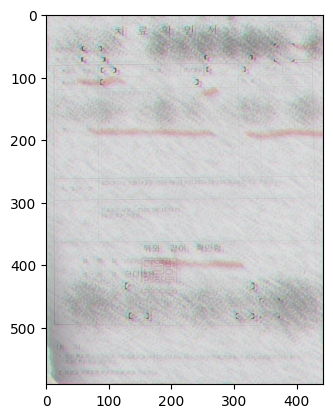

In [25]:
ink_phase = [
    InkBleed(
        intensity_range=(0.5, 0.6),
        kernel_size=random.choice([(5, 5), (3, 3)]),
        severity=(0.2, 0.4),
        p=0.33,
    ),
    OneOf(
        [
            InkShifter(
                text_shift_scale_range=(18, 27),
                text_shift_factor_range=(1, 4),
                text_fade_range=(0, 2),
                blur_kernel_size=(5, 5),
                blur_sigma=0,
                noise_type="random",
            ),
            BleedThrough(
                intensity_range=(0.1, 0.3),
                color_range=(32, 224),
                ksize=(17, 17),
                sigmaX=1,
                alpha=random.uniform(0.1, 0.2),
                offsets=(10, 20),
            ),
        ],
        p=1.0,
    ),
]

paper_phase = [
    ColorPaper(
        hue_range=(0, 255),
        saturation_range=(10, 40),
        p=0.33,
    ),
            OneOf(
        [
            DelaunayTessellation(
                n_points_range=(500, 800),
                n_horizontal_points_range=(500, 800),
                n_vertical_points_range=(500, 800),
                noise_type="random",
                color_list="default",
                color_list_alternate="default",
            ),
            PatternGenerator(
                imgx=random.randint(256, 512),
                imgy=random.randint(256, 512),
                n_rotation_range=(10, 15),
                color="random",
                alpha_range=(0.25, 0.5),
            ),
            VoronoiTessellation(
                mult_range=(50, 80),
                seed=19829813472,
                num_cells_range=(500, 1000),
                noise_type="random",
                background_value=(200, 255),
            ),
        ],
        p=1.0,
    ),
    AugmentationSequence(
        [
            NoiseTexturize(
                sigma_range=(3, 10),
                turbulence_range=(2, 5),
            ),
            BrightnessTexturize(
                texturize_range=(0.9, 0.99),
                deviation=0.03,
            ),
        ],
    ),
]

post_phase = [
    OneOf(
        [
            DirtyDrum(
                line_width_range=(1, 6),
                line_concentration=random.uniform(0.05, 0.15),
                direction=random.randint(0, 2),
                noise_intensity=random.uniform(0.6, 0.95),
                noise_value=(64, 224),
                ksize=random.choice([(3, 3), (5, 5), (7, 7)]),
                sigmaX=0,
                p=0.2,
            ),
            DirtyRollers(
                line_width_range=(2, 32),
                scanline_type=0,
            ),
        ],
        p=1.0,
    ),
    SubtleNoise(
        subtle_range=random.randint(5, 10),
        p=0.33,
    ),
    Jpeg(
        quality_range=(25, 95),
        p=0.33,
    ),

    OneOf(
        [
            Markup(
                num_lines_range=(2, 7),
                markup_length_range=(0.5, 1),
                markup_thickness_range=(1, 2),
                markup_type=random.choice(["strikethrough", "crossed", "highlight", "underline"]),
                markup_color="random",
                single_word_mode=False,
                repetitions=1,
            ),
            Scribbles(
                scribbles_type="random",
                scribbles_location="random",
                scribbles_size_range=(250, 600),
                scribbles_count_range=(1, 6),
                scribbles_thickness_range=(1, 3),
                scribbles_brightness_change=[32, 64, 128],
                scribbles_text="random",
                scribbles_text_font="random",
                scribbles_text_rotate_range=(0, 360),
                scribbles_lines_stroke_count_range=(1, 6),
            ),
        ],
        p=1.0,
    ),
            OneOf(
        [
            GlitchEffect(
                glitch_direction="random",
                glitch_number_range=(8, 16),
                glitch_size_range=(5, 50),
                glitch_offset_range=(10, 50),
            ),
            ColorShift(
                color_shift_offset_x_range=(3, 5),
                color_shift_offset_y_range=(3, 5),
                color_shift_iterations=(2, 3),
                color_shift_brightness_range=(0.9, 1.1),
                color_shift_gaussian_kernel_range=(3, 3),
            ),
        ],
        p=1.0,
    ),
    BadPhotoCopy(
        noise_type=-1,
        noise_side="random",
        noise_iteration=(1, 2),
        noise_size=(1, 3),
        noise_value=(128, 196),
        noise_sparsity=(0.3, 0.6),
        noise_concentration=(0.1, 0.6),
        blur_noise=random.choice([True, False]),
        blur_noise_kernel=random.choice([(3, 3), (5, 5), (7, 7)]),
        wave_pattern=random.choice([True, False]),
        edge_effect=random.choice([True, False]),
        p=0.33,
    ),

    Faxify(
        scale_range=(0.3, 0.6),
        monochrome=random.choice([0, 1]),
        monochrome_method="random",
        monochrome_arguments={},
        halftone=random.choice([0, 1]),
        invert=1,
        half_kernel_size=random.choice([(1, 1), (2, 2)]),
        angle=(0, 360),
        sigma=(1, 3),
        p=0.33,
    ),
]

pipeline = AugraphyPipeline(ink_phase=ink_phase, paper_phase=paper_phase, post_phase=post_phase)
img = cv2.imread(os.path.join(root_path, train_df.iloc[4, 0]))
augmented = pipeline(img)
plt.imshow(augmented)

## 적용할 것을 지정해서 수행

In [180]:
augmentations = [
    NoiseTexturize(sigma_range=(6, 10),
                  turbulence_range=(5, 10),
                  texture_width_range=(50, 500),
                  texture_height_range=(50, 500)),
    Folding(fold_count=2,
            fold_noise=0.0,
            fold_angle_range = (-180,180),
            gradient_width=(0.01, 0.1),
            gradient_height=(0.01, 0.1),
            backdrop_color = (0,0,0)),
    BadPhotoCopy(
        noise_type=0,
        noise_side="random",
        noise_iteration=(0, 10),
        noise_size=(1, 10),
        noise_value=(0, 100),
        noise_sparsity=(0.3, 1.0),
        noise_concentration=(0.5, 0.9),
        blur_noise=random.choice([True, False]),
        blur_noise_kernel=random.choice([(3, 3), (5, 5), (7, 7)]),
        wave_pattern=random.choice([True, False]),
        edge_effect=random.choice([True, False]),
        p=0.5,
    )
]

pipeline = AugraphyPipeline(augmentations)

3245

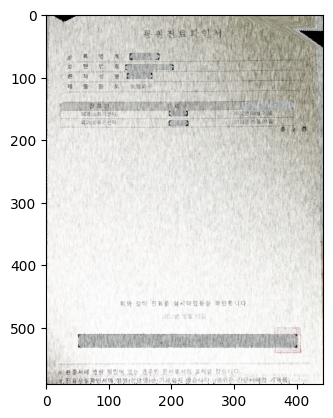

In [184]:
img = cv2.imread(os.path.join(root_path, train_df.iloc[101, 0]))
augmented = pipeline(img)
plt.imshow(augmented)

del img
gc.collect()

In [185]:
def process_chunk(chunk_range):
    for i in range(chunk_range[0], chunk_range[1]):
        img = cv2.imread(os.path.join(root_path, train_df.iloc[i, 0]))
        augmented = pipeline(img)
        save_path = os.path.join(save_path_root, train_df.iloc[i, 0])
        cv2.imwrite(save_path, augmented)

        del img, augmented, save_path
        gc.collect()

In [186]:
l = train_df.shape[0]
save_path_root = '/data/ephemeral/home/data/Augmentation/mask_deleted_augraphy/augmented1'

with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    futures = []
    for start in range(0, l, 175):
        chunk_range = (start, start + 175)
        future = executor.submit(process_chunk, chunk_range)
        futures.append(future)
        del future
        gc.collect()

print('END')

END


In [188]:
print(len(os.listdir('/data/ephemeral/home/data/Augmentation/mask_deleted_augraphy/augmented1')))

350


In [189]:
l = train_df.shape[0]

for i in range(2, 5):
    save_path_root = f'/data/ephemeral/home/data/Augmentation/mask_deleted_augraphy/augmented{i}'
    print(i, 'START', end=' ')

    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        futures = []
        for start in range(0, l, 175):
            chunk_range = (start, start + 175)
            future = executor.submit(process_chunk, chunk_range)
            futures.append(future)
            del future
            gc.collect()
        
    print('END')

2 START END
3 START END
4 START END


In [192]:
print(len(os.listdir('/data/ephemeral/home/data/Augmentation/mask_deleted_augraphy/augmented4')))

350


: 